In [1]:
import itk
import vtk
import matplotlib.pyplot as plt
import itkwidgets


# Fonction pour visualiser et lire

In [2]:
def read_file(file_path, image_type):
    reader = itk.ImageFileReader[image_type].New()
    reader.SetFileName(file_path)
    reader.Update()
    return reader.GetOutput()

In [3]:
image1_path = 'Data/case6_gre1.nrrd'
image2_path = 'Data/case6_gre2.nrrd'

In [4]:
image_1 = read_file(image1_path, itk.Image[itk.ctype('float'), 3])
image_2 = read_file(image2_path, itk.Image[itk.ctype('float'), 3])
print(type(image_1), type(image_2))
image_1.shape, image_2.shape


<class 'itk.itkImagePython.itkImageF3'> <class 'itk.itkImagePython.itkImageF3'>


((176, 256, 256), (176, 256, 256))

In [5]:
def display_images(image1, image2, slice_number):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image1[slice_number, :, :], cmap='gray')
    plt.title(f"Slice {slice_number}")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image2[slice_number, :, :], cmap='gray')
    plt.title(f"Slice {slice_number}")
    plt.axis('off')
    plt.show()

In [11]:
def visualize_image3D(image):
    # Convert the input image to a numpy array
    image_array = itk.array_view_from_image(image)

    # Visualize the image using itkwidgets
    viewer = itkwidgets.view(image_array)
    return viewer

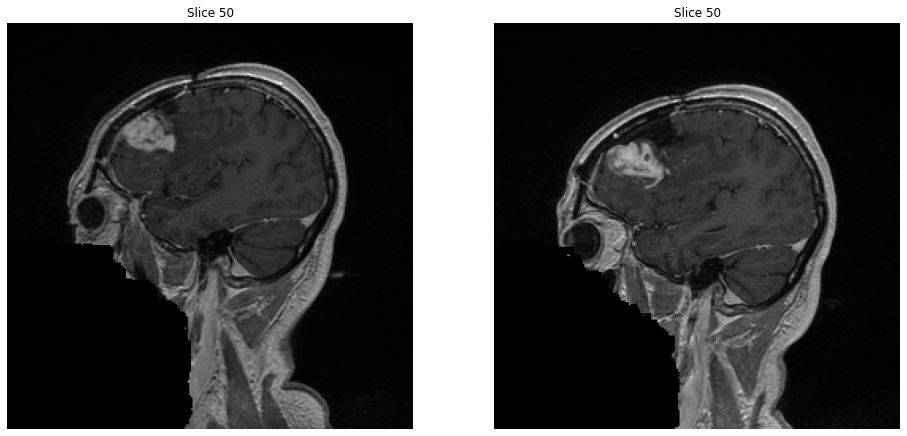

In [6]:
display_images(image_1, image_2, 50)

# Partie 1 : Recalage


Méthode Rigide

In [7]:
def image_registration_rigid(fixed_image=image_1,moving_image=image_2):
    imagetype = itk.Image[itk.ctype('float'), 3]

    #define transform type
    TransformType = itk.VersorRigid3DTransform[itk.D]
    initial_transform = TransformType.New()

    #define optimizer
    optimizer = itk.RegularStepGradientDescentOptimizerv4[itk.D].New(
        LearningRate=0.1,
        MinimumStepLength=0.001,
        RelaxationFactor=0.5,
        NumberOfIterations=200,
        ReturnBestParametersAndValue=True
    )

    
    #define metric
    metric = itk.MeanSquaresImageToImageMetricv4[imagetype, imagetype].New()

    # define de registration method
    registration = itk.ImageRegistrationMethodv4[imagetype,imagetype].New(
        FixedImage=fixed_image, 
        MovingImage=moving_image, 
        Metric=metric,
        Optimizer=optimizer, 
        InitialTransform=initial_transform,
    )
    registration.SetNumberOfLevels(1)
    registration.SetSmoothingSigmasPerLevel([0])
    registration.SetShrinkFactorsPerLevel([1])
    
    
    TransformInitializerType = itk.CenteredTransformInitializer[TransformType, imagetype, imagetype]
    initializer = TransformInitializerType.New(
        Transform=initial_transform,
        FixedImage=fixed_image,
        MovingImage=moving_image
    )
    initializer.MomentsOn()
    initializer.InitializeTransform()

    OptimizerScalesType = itk.OptimizerParameters[itk.D]
    optimizer_scales = OptimizerScalesType(initial_transform.GetNumberOfParameters())

    optimizer_scales[0] = 1.0
    optimizer_scales[1] = 1.0
    optimizer_scales[2] = 1.0
    optimizer_scales[3] = 1.0 / 1000.0
    optimizer_scales[4] = 1.0 / 1000.0
    optimizer_scales[5] = 1.0 / 1000.0

    optimizer.SetScales(optimizer_scales)

    registration.Update()

    transform = registration.GetTransform()
    final_parameters = transform.GetParameters()
    angle = final_parameters.GetElement(0)
    translation_along_x = final_parameters.GetElement(1)
    translation_along_y = final_parameters.GetElement(2)
    translation_along_z = final_parameters.GetElement(3)
    number_of_iterations = optimizer.GetCurrentIteration()
    best_value = optimizer.GetValue()

    print("Result = ")
    print(" Angle = " + str(angle))
    print(" Translation X = " + str(translation_along_x))
    print(" Translation Y = " + str(translation_along_y))
    print(" Translation Z = " + str(translation_along_z))
    print(" Iterations    = " + str(number_of_iterations))
    print(" Metric value  = " + str(best_value))

    finalTransform = TransformType.New()
    finalTransform.SetFixedParameters(registration.GetOutput().Get().GetFixedParameters())
    finalTransform.SetParameters(registration.GetOutput().Get().GetParameters())


    # Resample the moving image using the final transform to make a 
    resample = itk.ResampleImageFilter[imagetype, imagetype].New()
    resample.SetTransform(finalTransform)
    resample.SetInput(moving_image)
    resample.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
    resample.SetOutputOrigin(fixed_image.GetOrigin())
    resample.SetOutputSpacing(fixed_image.GetSpacing())
    resample.SetOutputDirection(fixed_image.GetDirection())
    resample.SetDefaultPixelValue(100)
    resample.Update()
    return resample.GetOutput()
    

In [8]:
registered_image = image_registration_rigid(image_1, image_2)

Result = 
 Angle = 0.0011300177987591449
 Translation X = -0.007763075269564344
 Translation Y = 0.024059544152215197
 Translation Z = -1.1528900645083608
 Iterations    = 141
 Metric value  = 9321.632033205125


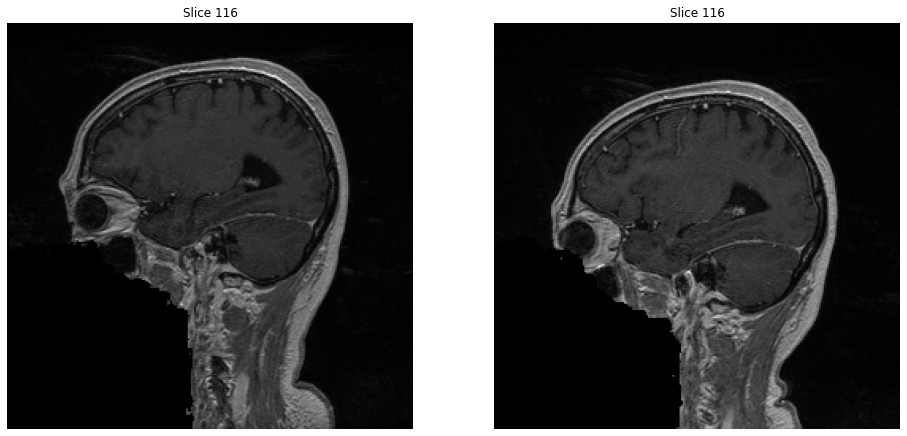

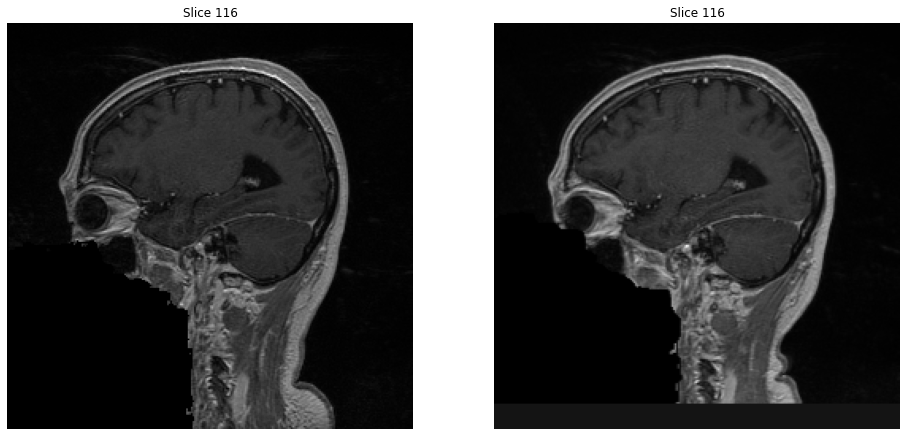

In [10]:
display_images(image_1, image_2, 116)
display_images(image_1, registered_image, 116)

In [13]:
visualize_image3D(registered_image)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

Méthode Transformation Affine


In [ ]:
def image_registration_affine():
    return None

# Partie 2 : Segmentation


# Partie 3 : Comparaison des différences
